# 공유 자전거 수요 예측 (11.30 고지혜)

### 라이브러리 및 데이터 불러오기

In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd 

# 시각화 라이브러리
import matplotlib.pyplot as plt 
import seaborn as sns

# 모델링을 위한 sklearn 패키지
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# score를 내줄 함수
from sklearn.metrics import make_scorer

# 모델링에 활용한 패키지
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import warnings
warnings.filterwarnings('ignore')

C:\Users\Berry\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\Berry\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

In [2]:
# 데이터 불러오기

train = pd.read_csv('C:/Users/Berry/Documents/GitHub/DeeplearningStudy/고지혜/prepro_train.csv')
test = pd.read_csv('C:/Users/Berry/Documents/GitHub/DeeplearningStudy/고지혜/prepro_test.csv')

In [3]:
test.max()

datetime            2012-12-31 23:00:00
holiday                               1
workingday                            1
atemp                                 1
humidity                              1
windspeed                             1
rainyday                              1
ideal                                 1
sticky                                1
peak                                  1
temp(difference)                      1
discomfort_index                      1
hour_0                                1
hour_1                                1
hour_2                                1
hour_3                                1
hour_5                                1
hour_6                                1
hour_7                                1
hour_8                                1
hour_9                                1
hour_10                               1
hour_11                               1
hour_12                               1
hour_13                               1


### 베이스라인 모델링
특정 기법을 통해 학습 및 평가했을 때, 기존의 모델보다 좋아졌는지 판단하기 위해 기준으로 삼을 베이스라인 모델을 생성한다.

In [4]:
# 전처리한 변수들이 있는데 이 중에서 분석에 활용한 변수를 선택해줍시다.
# 기존 데이터에 덮어쓰기보단 train_copy라는 예비 데이터프레임을 생성하여 저장해줍시다.
train_copy = train

col = ['holiday', 'workingday', 'atemp', 'humidity', 'windspeed',
       'rainyday', 'ideal', 'sticky', 'peak', 'temp(difference)',
       'discomfort_index', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'hw_0', 'hw_1',
       'hw_2', 'hw_3', 'hw_5', 'hw_6', 'hw_7', 'hw_8', 'hw_9', 'hw_10',
       'hw_11', 'hw_12', 'hw_13', 'hw_14', 'hw_15', 'hw_16', 'hw_17', 'hw_18',
       'hw_19', 'hw_20', 'hw_21', 'hw_22', 'hw_23', 'year_2012', 'dayofweek_0',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5',
       'dayofweek_6', 'season_2', 'season_3', 'season_4', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12']

# count를 제외한 변수들을 담은 데이터프레임.
X_features = train[col]
X_test = test[col]

# 타겟 변수는 log 처리를 해준 count 변수
target = train['log_count']

# 데이터를 나눠줌
#X_train, X_valid, y_train, y_valid = train_test_split(X_features, target, test_size = 0.3, random_state = 0)

In [5]:
train.columns

Index(['datetime', 'holiday', 'workingday', 'atemp', 'humidity', 'windspeed',
       'log_count', 'rainyday', 'ideal', 'sticky', 'peak', 'temp(difference)',
       'discomfort_index', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'hw_0', 'hw_1',
       'hw_2', 'hw_3', 'hw_5', 'hw_6', 'hw_7', 'hw_8', 'hw_9', 'hw_10',
       'hw_11', 'hw_12', 'hw_13', 'hw_14', 'hw_15', 'hw_16', 'hw_17', 'hw_18',
       'hw_19', 'hw_20', 'hw_21', 'hw_22', 'hw_23', 'year_2012', 'dayofweek_0',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5',
       'dayofweek_6', 'season_2', 'season_3', 'season_4', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12'],
      dtype='object')

In [6]:
# RMSLE 값을 출력하는 함수
def rmsle(y,y_,convertExp=True):
    # 지수화 필요하다면
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [7]:
## cross val score를 측정해주는 함수
def cv_score(models, n = 5):
    # kfold 수는 default인 5로 지정
    kf = KFold(n_splits = n, shuffle=True, random_state = 0)
    
    for model in models:
#       model.fit(X_train,y_train)
        score =  cross_val_score(model, X_features, target, cv = kf, scoring=rmsle_scorer)
        print(model[0],'의 평균 score:', round(score.mean(), 5))
        print(model[0],'의 std:', round(score.std(), 5))
        print()      
        
        # y_valid과 prediction을 비교하여 시각화 해주는 코드
#        g = sns.kdeplot(np.exp(y_valid),  color = 'skyblue', alpha = .6, fill = True, label = 'valid')
#        g = sns.kdeplot(np.exp(model.predict(X_valid)), color = 'orange', alpha = .3, fill = True, label = 'prediction')
#       plt.legend()
#        plt.show()

In [8]:
## 제출을 위한 함수
def submission(model):
    model.fit(X_features, target)
    prediction = np.exp(model.predict(X_test))
    
    # 자동으로 형식을 맞춰 csv 생성해주는 코드
    submission = pd.DataFrame(test['datetime'])
    submission['count'] = prediction

    pd.DataFrame(submission).to_csv('submission_bike.csv', index = False)
    
    return pd.DataFrame(submission)

In [9]:
from sklearn.linear_model import ElasticNet
# 기본 모델을 아래와 같이 5가지로 정했음.                                             mean val_score    std
pipe_lr = Pipeline([('model', LinearRegression())])                                 #   0.33503     / 0.00783
#pipe_rf = Pipeline([('model', RandomForestRegressor(n_estimators=500))])            #   0.4394      / 0.01136 
#pipe_lgbm = Pipeline([('model', LGBMRegressor(n_estimators=100))])                  #   0.32172     / 0.0055
#pipe_gb = Pipeline([('model', GradientBoostingRegressor())])                        #   0.59616     / 0.01654
#pipe_xgb = Pipeline([('model', XGBRegressor(objective ='reg:squarederror'))])       #   0.59705     / 0.0167

#models = [pipe_lr, pipe_rf, pipe_lgbm, pipe_gb, pipe_xgb]
models = [pipe_lr]
# 평균 valid score 측정
cv_score(models)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 의 평균 score: 0.33474
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 의 std: 0.00817



In [10]:
reg = LinearRegression().fit(X_features, target)
reg.score(X_features, target)

0.9390927569314109

In [11]:
reg.coef_

array([ 5.40241104e+12,  5.40241104e+12,  9.19921875e-01, -3.36914062e-01,
       -2.75878906e-01, -5.06347656e-01,  4.02832031e-02, -1.53808594e-02,
       -6.39923805e+11,  1.27899170e-01,  1.42944336e-01,  2.25283813e+00,
        2.01247406e+00,  1.72835541e+00,  9.96231079e-01,  4.02832031e-03,
        6.25808716e-01,  1.49563599e+00,  2.37511444e+00,  2.85756683e+00,
        6.39923805e+11,  6.39923805e+11,  6.39923805e+11,  6.39923805e+11,
        6.39923805e+11,  6.39923805e+11,  6.39923805e+11,  6.39923805e+11,
        6.39923805e+11,  6.39923805e+11,  2.84968567e+00,  2.63718414e+00,
        2.45750427e+00,  2.16382599e+00, -5.68695068e-01, -1.10830688e+00,
       -1.41436768e+00, -1.09466553e+00,  1.39697266e+00,  2.22744751e+00,
        2.36804199e+00,  6.39923805e+11,  8.15826416e-01, -6.39923805e+11,
       -6.39923805e+11, -2.23175049e-01, -2.60711670e-01, -6.39923805e+11,
       -6.39923805e+11, -6.39923805e+11,  8.73138428e-01,  9.85107422e-01,
       -6.39923805e+11,  

In [12]:
reg.intercept_

-5402411039922.023

In [13]:
reg.predict(X_test)

array([2.52148438e+00, 1.81445312e+00, 1.22460938e+00, ...,
       2.34646375e+11, 2.34646375e+11, 2.34646375e+11])

In [14]:
reg.predict(X_test).tolist()

[2.521484375,
 1.814453125,
 1.224609375,
 0.8349609375,
 0.93359375,
 2.26953125,
 3.705078125,
 4.7373046875,
 5.224609375,
 4.5751953125,
 3.9267578125,
 4.111328125,
 4.3525390625,
 4.3154296875,
 4.2158203125,
 4.298828125,
 4.68359375,
 5.3359375,
 5.1767578125,
 4.765625,
 4.4423828125,
 4.1572265625,
 3.84765625,
 3.3876953125,
 2.59765625,
 1.8173828125,
 0.7392578125,
 0.2314453125,
 0.904296875,
 2.283203125,
 3.8115234375,
 4.8037109375,
 5.3125,
 4.583984375,
 3.9072265625,
 4.041015625,
 4.267578125,
 4.2333984375,
 4.1337890625,
 4.208984375,
 4.646484375,
 5.255859375,
 5.224609375,
 4.841796875,
 4.443359375,
 4.1826171875,
 3.8291015625,
 3.427734375,
 3.4228515625,
 3.1376953125,
 2.916015625,
 2.1728515625,
 1.123046875,
 1.7998046875,
 2.6416015625,
 3.498046875,
 4.044921875,
 4.4658203125,
 4.685546875,
 4.849609375,
 4.8486328125,
 4.8837890625,
 4.8759765625,
 4.8603515625,
 4.79296875,
 4.5517578125,
 4.4033203125,
 4.0830078125,
 3.927734375,
 3.67578125,
 3.

In [15]:
ttt = pd.DataFrame()
ttt['x_test'] = reg.predict(X_test).tolist() 

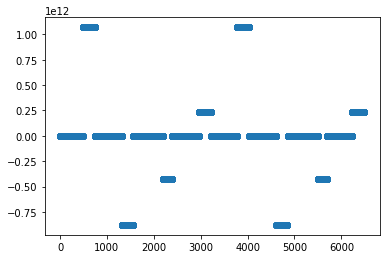

In [16]:
plt.scatter(ttt.index,ttt['x_test'])

In [17]:
# lr 모델 제출 결과 : => inf 값 나와서 실패.. 왜지...
# rf 모델 제출 결과 : 0.52784  **
# lgbm 모델 제출 결과 : 0.41477  **
# gb 모델 제출 결과 : 0.66858
# xgb 모델 제출 결과 : 0.52387  **

submission(pipe_lr)

,datetime,count
0,2011-01-20 00:00:00,12.447059
1,2011-01-20 01:00:00,6.137719
2,2011-01-20 02:00:00,3.402837
3,2011-01-20 03:00:00,2.304724
4,2011-01-20 04:00:00,2.543634
5,2011-01-20 05:00:00,9.674865
6,2011-01-20 06:00:00,40.653223
7,2011-01-20 07:00:00,114.126181
8,2011-01-20 08:00:00,185.788583
9,2011-01-20 09:00:00,97.046992


In [38]:
pd.set_option('display.max_columns', None)


X_test['y_pred'] = ttt['x_test']
group_inf= X_test.query('y_pred>10000000')
group_not_inf = X_test.query('y_pred<=10000000')
group_inf.tail(10)

,holiday,workingday,atemp,humidity,windspeed,rainyday,ideal,sticky,peak,temp(difference),discomfort_index,hour_0,hour_1,hour_2,hour_3,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hw_0,hw_1,hw_2,hw_3,hw_5,hw_6,hw_7,hw_8,hw_9,hw_10,hw_11,hw_12,hw_13,hw_14,hw_15,hw_16,hw_17,hw_18,hw_19,hw_20,hw_21,hw_22,hw_23,year_2012,dayofweek_0,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,season_2,season_3,season_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,y_pred
6483,0,1,0.2727,0.345238,0.179979,0,0,0,0,0.702044,0.304940,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.346464e+11
6484,0,1,0.2879,0.345238,0.059904,0,0,0,0,0.642296,0.304940,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.346464e+11
6485,0,1,0.2576,0.380952,0.139909,0,0,0,0,0.696541,0.282769,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.346464e+11
6486,0,1,0.2879,0.380952,0.000000,0,0,0,1,0.577830,0.282769,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.346464e+11
6487,0,1,0.2727,0.380952,0.059904,0,0,0,1,0.637579,0.282769,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.346464e+11
6488,0,1,0.2576,0.523810,0.099973,0,0,0,0,0.696541,0.274018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.346464e+11
6489,0,1,0.2576,0.523810,0.099973,0,0,0,0,0.696541,0.274018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.346464e+11
6490,0,1,0.2576,0.523810,0.099973,0,0,0,0,0.696541,0.274018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.346464e+11
6491,0,1,0.2727,0.476190,0.059904,0,0,0,0,0.637579,0.276935,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.346464e+11
6492,0,1,0.2727,0.583333,0.059904,0,0,0,0,0.637579,0.270323,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.346464e+11


In [39]:
group_not_inf.tail(10)

,holiday,workingday,atemp,humidity,windspeed,rainyday,ideal,sticky,peak,temp(difference),discomfort_index,hour_0,hour_1,hour_2,hour_3,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hw_0,hw_1,hw_2,hw_3,hw_5,hw_6,hw_7,hw_8,hw_9,hw_10,hw_11,hw_12,hw_13,hw_14,hw_15,hw_16,hw_17,hw_18,hw_19,hw_20,hw_21,hw_22,hw_23,year_2012,dayofweek_0,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,season_2,season_3,season_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,y_pred
6221,0,1,0.3485,0.440476,0.139909,0,0,0,0,0.661164,0.385453,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5.370117
6222,0,1,0.3333,0.488095,0.139909,0,0,0,0,0.657233,0.363866,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5.423828
6223,0,1,0.3030,0.440476,0.320021,0,0,0,0,0.775943,0.364255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5.775391
6224,0,1,0.3333,0.595238,0.139909,0,0,0,1,0.657233,0.362894,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,6.419922
6225,0,1,0.3333,0.654762,0.139909,0,0,0,1,0.657233,0.362505,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,6.348633
6226,0,1,0.3182,0.654762,0.219914,1,0,0,0,0.716195,0.362505,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5.464844
6227,0,1,0.3333,0.714286,0.099973,1,0,0,0,0.657233,0.361921,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5.156250
6228,0,1,0.3333,0.714286,0.099973,1,0,0,0,0.657233,0.361921,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4.877930
6229,0,1,0.3333,0.845238,0.139909,1,0,0,0,0.657233,0.360949,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4.549805
6230,0,1,0.4091,0.785714,0.279952,1,1,0,0,0.551887,0.438934,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4.197266


[RMSLE 평가 지표에 대해](https://ahnjg.tistory.com/90)

요약 
1. 큰 것보다 적은 것을 오차없이 예측할 때 점수가 더 좋음.
2. under estimator에 대해 페널티를 부과한다. <b> 예측값 > 실제값</b> 보다 <b>예측값 < 실제값</b>일 때, 점수가 안 좋음.

## 파라미터 찾기

In [18]:
def search_params(x = X_features, y = target, model, paras, n = 5, scorer = rmsle_scorer) :
    # pipeline 으로 받은 모델을 부르고
    model = model['model']

    # kfold 
    kf = KFold(n_splits = n, shuffle=True, random_state = 0)

    grid_model = GridSearchCV(estimator = model, param_grid = paras, cv=kf, n_jobs=-1, verbose=2, scoring = scorer)
    grid_model.fit(x,y)
    
    # grid_search한 결과를 Dataframe화
    scores_df = pd.DataFrame(grid_model.cv_results_)
    scores_df[['params', 'mean_test_score','rank_test_score', 'split0_test_score', 'split1_test_score','split2_test_score']]
    
    # GridSearchCV 의 best score는 높은 점수를 알려줌. 
    # 즉, 현재 우리의 평가지표(rslme)는 낮은 점수일수록 좋은 평가이기 때문에 score를 오름차순으로 정렬해서 확인
    scores_df = scores_df.sort_values('mean_test_score', ascending = True).loc[:,['params','mean_test_score']]

    return(scores_df)

SyntaxError: non-default argument follows default argument (<ipython-input-18-fd5f82e120eb>, line 1)

In [ ]:
#lgbm에 대한 parameters
para_lgbm = [{
    'learning_rate' : [0.01, 0.03, 0.05, 0.07, 0.1],
    'n_estimators' : [500, 800, 1000, 1300, 1500],
    'random_state' : [0]}]
    
search_params(X_features, target, pipe_lgbm, para_lgbm)

1000/0.03 이 best score인 것을 확인할 수 있음

In [ ]:
# lgbm (1500, 0.03, random_state = 0)
pipe_lgbm4 = Pipeline([('model', LGBMRegressor(n_estimators=1500, learning_rate = 0.03))])

submission(pipe_lgbm4) # 0.399

In [ ]:
cv_lgbm5 = Pipeline([('model', LGBMRegressor(n_estimators=1500, learning_rate = 0.03, random_state=0))])
model5 = [cv_lgbm5]
cv_score(model5)     

#   파라미터 조정 후         파라미터 조정 전
# 0.28621  / 0.00548   =>    0.32172  / 0.0055

---

### *참고 ) 헤매는동안 살펴본 값들*


In [ ]:
# grid_lgbm2 = LGBMRegressor()
# #
# kf = KFold(n_splits = 5, shuffle=True, random_state = 0)

# grid_lgbm2 = GridSearchCV(estimator = grid_lgbm2, param_grid = para_lgbm, cv=kf, n_jobs=-1, verbose=2, scoring = rmsle_scorer)
# grid_lgbm2.fit(X_features, target)

# #lgbm 
# print("lgbm best param is : ", grid_lgbm2.best_params_)
# print("lgbm best score is : ", grid_lgbm2.best_score_)

In [ ]:
# pipe_lgbm2 = Pipeline([('model', LGBMRegressor(n_estimators=500, learning_rate = 0.01, random_state = 0))])

# submission(pipe_lgbm2) # 0.46298

In [ ]:
# pipe_lgbm3 = Pipeline([('model', LGBMRegressor(n_estimators=1000, learning_rate = 0.05, random_state = 0))])
# submission(pipe_lgbm3)  # 0.39642

In [ ]:
# pipe_lgbm4 = Pipeline([('model', LGBMRegressor(n_estimators=1000, learning_rate = 0.07, random_state = 0))])
# submission(pipe_lgbm4)   # 0.404

In [ ]:
# cv_lgbm = Pipeline([('model', LGBMRegressor(n_estimators=500, learning_rate = 0.01))])
# model1 = [cv_lgbm]
# cv_score(model1)

In [ ]:
# cv_lgbm2 = Pipeline([('model', LGBMRegressor(n_estimators=1000, learning_rate = 0.05, random_state=0))])
# model2 = [cv_lgbm2]
# cv_score(model2)

In [ ]:
# cv_lgbm3 = Pipeline([('model', LGBMRegressor(n_estimators=1000, learning_rate = 0.07, random_state=0))])
# model3 = [cv_lgbm3]
# cv_score(model3)

In [ ]:
# scores_df.sort_values('mean_test_score', ascending = True).loc[:,['params','mean_test_score']]

---

## 앞으로 찾아야할 파라미터값들

In [ ]:
para_xgb = [{
    'eta' : [0.01, 0.05, 0.1, 0.15, 0.2], 
    'gamma' : [0, 0.3, 0.5],
    'max_depth': [4, 6, 8],
    'random_state' : [0],
    'objective' : ['reg:squarederror']}]

grid_xgb = XGBRegressor()


xgb_para = GridSearchCV(estimator = grid_xgb, param_grid = para_xgb, cv=10, n_jobs=-1, verbose=2, scoring = rmsle_scorer)
xgb_para.fit(X_features, target)

In [ ]:
print("xgb best param is : ", xgb_para.best_params_)
print("xgb best score is : ", xgb_para.best_score_)

In [ ]:
pipe_xgb2 = Pipeline([('model', XGBRegressor(eta = 0.01, gamma= 0.3, max_depth= 4, objective= 'reg:squarederror', random_state= 0))])
submission(pipe_xgb2)  # 1.7656

In [ ]:
#rf에 대한 parameters
para_rf = [{
    'max_depth' : [6, 8, 10, 12, 14],
    'n_estimators' : [100,200,300,400,500],
    'min_samples_split' : [2, 5, 7,10],
    'min_samples_leaf' : [1, 2, 4],
    'random_state' : [0]}]
